In [3]:
# 모듈 불러오기
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import joblib
import matplotlib.pyplot as plt
import time
import os

In [4]:
# 데이터 불러오기
df_normal = pd.read_excel('../dataset/preprocessed/50ohm_정상_train.xlsx')
df_arc = pd.read_excel('../dataset/preprocessed/50ohm_아크_train.xlsx')
test_df = pd.read_excel('../dataset/preprocessed/50ohm_통합_test.xlsx')

# 컬럼명 통일
df_normal = df_normal.rename(columns={'power_voltage': 'voltage', 'power_current': 'current'})
df_arc = df_arc.rename(columns={'arc_voltage': 'voltage', 'arc_current': 'current'})
test_df = test_df.rename(columns={'power_voltage': 'voltage', 'power_current': 'current'})

# 라벨 추가
df_normal['label'] = 0
df_arc['label'] = 1

train_df = pd.concat([df_normal, df_arc], ignore_index=True)

In [5]:
# 파생 피처 함수 정의
def add_features(df):
    df['voltage_diff'] = df['voltage'].diff().fillna(0).abs()
    df['current_diff'] = df['current'].diff().fillna(0).abs()
    df['voltage_ma'] = df['voltage'].rolling(5).mean().bfill()
    df['current_ma'] = df['current'].rolling(5).mean().bfill()
    df['power'] = df['voltage'] * df['current']
    df['power_diff'] = df['power'].diff().fillna(0).abs()
    return df

train_df = add_features(train_df)
test_df = add_features(test_df)

In [6]:
# 피처 및 라벨 설정
features = ['voltage', 'current', 'voltage_diff', 'current_diff',
            'voltage_ma', 'current_ma', 'power', 'power_diff']
X_train = train_df[features].values
y_train = train_df['label'].values

X_test = test_df[features].values
y_test = test_df['label'].values


# 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# RandomForest 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# 모델 저장
joblib.dump(model, './model/random_forest_model.joblib')
joblib.dump(scaler, './model/scaler_rf.joblib')

['./model/scaler_rf.joblib']

In [8]:
# 예측 및 평가
y_pred = model.predict(X_test_scaled)

In [9]:
def postprocess_anomalies(y_pred_bin, min_consecutive=8):
    y_post = np.zeros_like(y_pred_bin)
    count = 0
    for i, val in enumerate(y_pred_bin):
        if val == 1:
            count += 1
        else:
            if count >= min_consecutive:
                y_post[i - count:i] = 1
            count = 0
    if count >= min_consecutive:
        y_post[len(y_pred_bin)-count:] = 1
    return y_post

y_pred_post = postprocess_anomalies(y_pred, min_consecutive=8)
y_true_post = postprocess_anomalies(y_test, min_consecutive=8)

In [10]:
print("📋 (후처리 적용) 분류 리포트:\n")
print(classification_report(y_true_post, y_pred_post, target_names=['정상', '아크']))

📋 (후처리 적용) 분류 리포트:

              precision    recall  f1-score   support

          정상       0.95      1.00      0.97       480
          아크       1.00      0.58      0.73        64

    accuracy                           0.95       544
   macro avg       0.97      0.79      0.85       544
weighted avg       0.95      0.95      0.94       544



In [11]:
def calculate_detection_delay(y_pred_bin, label, sampling_interval=0.0001):
    arc_start = np.where(label == 1)[0][0] # 아크의 시작 인덱스 찾기
    detected = np.where(y_pred_bin[arc_start:] == 1)[0] # 예측 값에서 아크를 처음 발견한 인덱스 찾기
    if len(detected) == 0:
        print("⚠️ 아크를 탐지하지 못했습니다.")
        return None
    detect_index = detected[0] + arc_start
    delay = detect_index - arc_start
    time_detected = detect_index * sampling_interval
    print(f"✅ 아크 시작 인덱스: {arc_start}")
    print(f"✅ 모델 이상 감지 인덱스: {detect_index}")
    print(f"⏱️ 감지 지연 시간: {delay} 샘플")
    print(f"⏱️ 감지된 시점 (초): {time_detected:.6f} 초")
    return arc_start, detect_index, delay

arc_start, detect_index, delay = calculate_detection_delay(y_pred_post, y_true_post)

✅ 아크 시작 인덱스: 240
✅ 모델 이상 감지 인덱스: 265
⏱️ 감지 지연 시간: 25 샘플
⏱️ 감지된 시점 (초): 0.026500 초


In [12]:
import time

# 전체 예측 시간
start_total = time.perf_counter()
y_pred = model.predict(X_test_scaled)
elapsed_total = time.perf_counter() - start_total
print(f"⏱️ 전체 예측 소요 시간: {elapsed_total:.10f}초")

# 후처리 + 첫 이상 감지까지 시간
start_first = time.perf_counter()
y_pred_post = postprocess_anomalies(y_pred, min_consecutive=8)
first_index = np.where(y_pred_post == 1)[0]
elapsed_first = time.perf_counter() - start_first

if len(first_index) > 0:
    print(f"🟡 첫 번째 이상 탐지 인덱스: {first_index[0]}")
    print(f"⏱️ 첫 이상 탐지까지 걸린 시간: {elapsed_first:.10f}초")
else:
    print("⚠️ 후처리된 이상 탐지 결과가 없습니다.")


⏱️ 전체 예측 소요 시간: 0.0334570170초
🟡 첫 번째 이상 탐지 인덱스: 265
⏱️ 첫 이상 탐지까지 걸린 시간: 0.0014788090초


---
# 시각화 자료

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (예: 맑은 고딕)
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자
# plt.rcParams['font.family'] = 'AppleGothic'   # macOS 사용자
plt.rcParams['font.family'] = 'NanumGothic'   # Linux 사용자 (Nanum 폰트 설치 필요)

# 마이너스 부호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_3275/1726938352.py:15: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/1726938352.py:15: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/1726938352.py:15: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/1726938352.py:15: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/1726938352.py:15: UserWarni

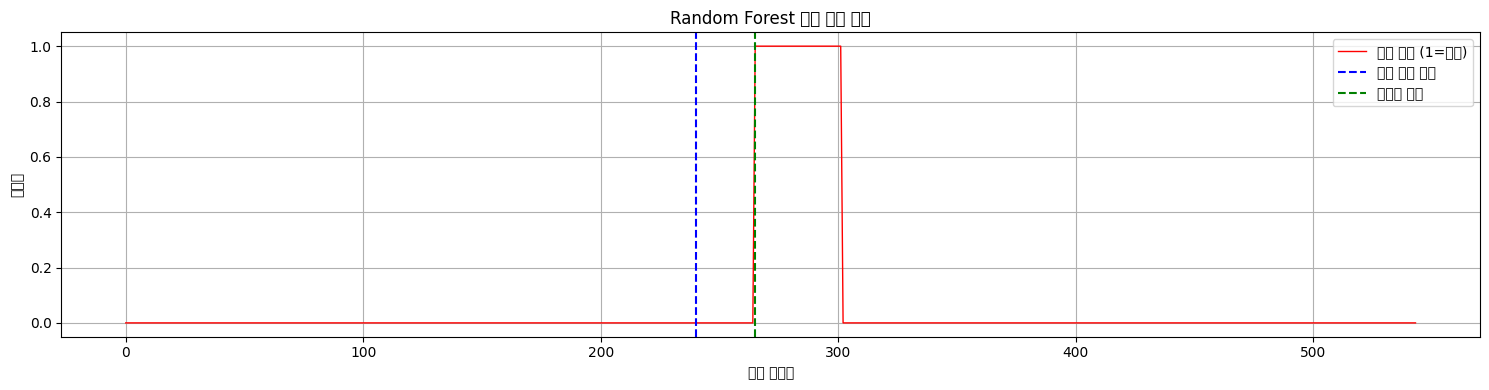

In [14]:
def plot_predictions(y_pred_bin, arc_start=None, detect_index=None):
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred_bin, label='예측 이상 (1=이상)', color='red', linewidth=1)

    if arc_start is not None:
        plt.axvline(x=arc_start, color='blue', linestyle='--', label='실제 아크 시작')
    if detect_index is not None:
        plt.axvline(x=detect_index, color='green', linestyle='--', label='감지된 시점')

    plt.title("Random Forest 이상 탐지 결과")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("예측값")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions(y_pred_post, arc_start, detect_index)

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_3275/307965161.py:8: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/307965161.py:8: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/307965161.py:8: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/307965161.py:8: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/307965161.py:8: UserWarning: Glyph 

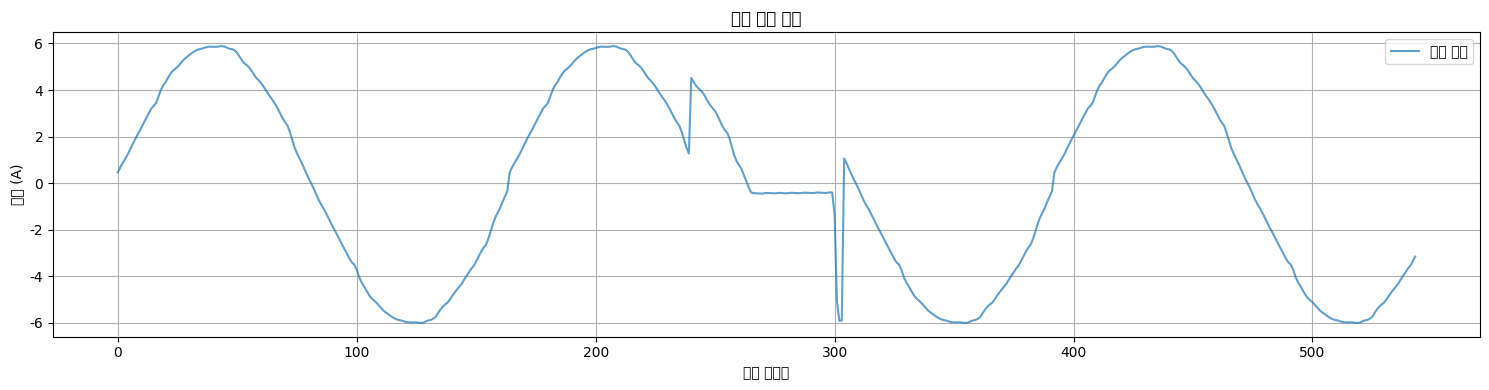

In [15]:
def plot_current_waveform(test_df):
    plt.figure(figsize=(15, 4))
    plt.plot(test_df['current'], label='전류 파형', alpha=0.7)
    plt.title("전체 전류 파형")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("전류 (A)")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_current_waveform(test_df)

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


/tmp/ipykernel_3275/441081179.py:10: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/441081179.py:10: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/441081179.py:10: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/441081179.py:10: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/441081179.py:10: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
fi

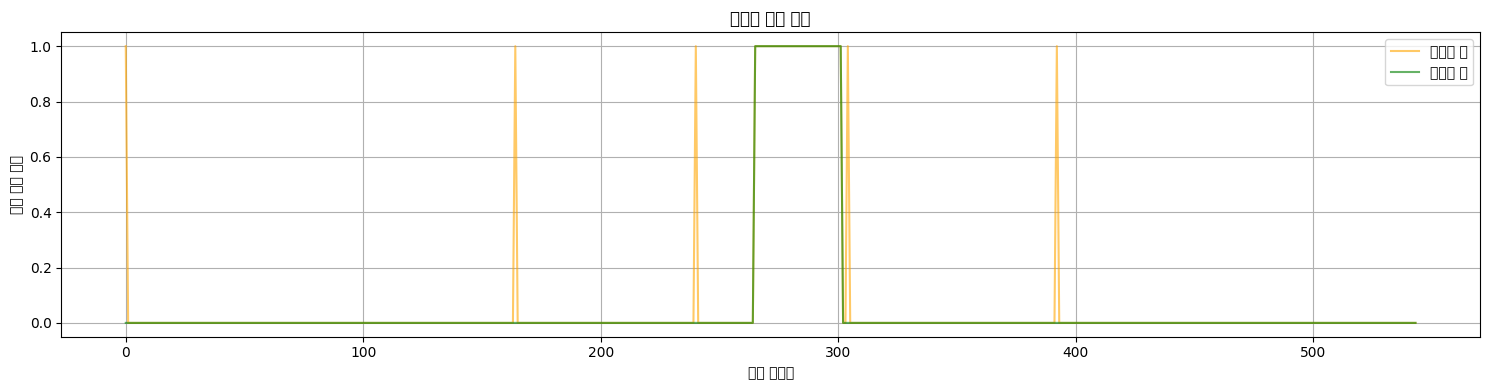

In [16]:
def compare_postprocessing(y_pred_bin, y_pred_post, title="후처리 전후 비교"):
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred_bin, label='후처리 전', color='orange', alpha=0.6)
    plt.plot(y_pred_post, label='후처리 후', color='green', alpha=0.6)
    plt.title(title)
    plt.xlabel("샘플 인덱스")
    plt.ylabel("이상 탐지 결과")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_postprocessing(y_pred, y_pred_post)




findfont: Font family 'NanumGothic' not found.


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_3275/2144239638.py:10: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/2144239638.py:10: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/2144239638.py:10: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/2144239638.py:10: UserWarning: Glyph 45937 (\N{HANGUL SYLLABLE DEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3275/2144239638.py:10: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missi

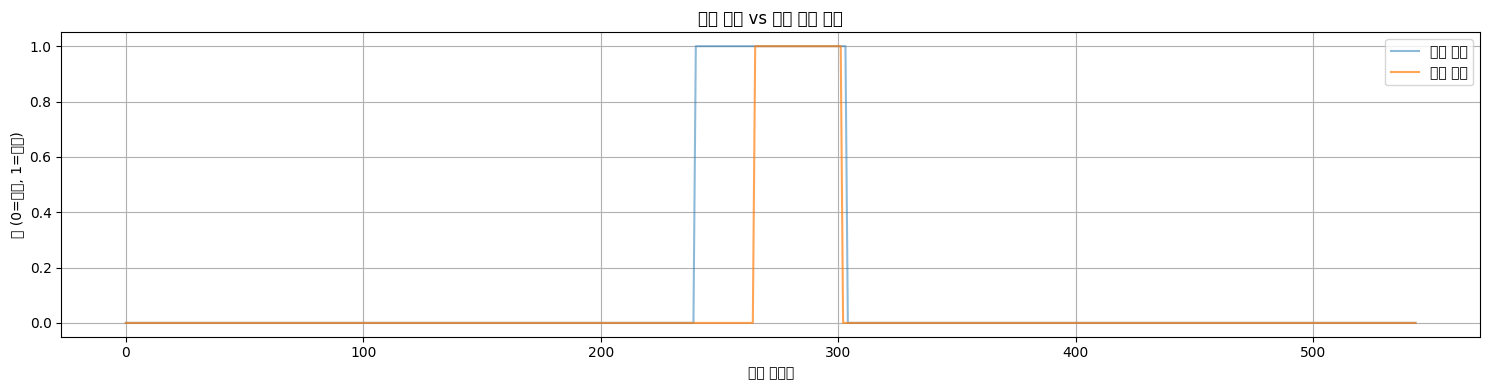

In [17]:
def compare_prediction_vs_label(y_true, y_pred_post):
    plt.figure(figsize=(15, 4))
    plt.plot(y_true, label='실제 라벨', alpha=0.5)
    plt.plot(y_pred_post, label='모델 예측', alpha=0.7)
    plt.title("실제 라벨 vs 모델 예측 비교")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("값 (0=정상, 1=아크)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_prediction_vs_label(y_true_post, y_pred_post)

# # 차이점 위치 찾기
# mismatch_indices = np.where(y_true_post != y_pred_post)[0]
# print("불일치 인덱스:", mismatch_indices)
# print("불일치 개수:", len(mismatch_indices))